#말라리아 감염 구분 


google drive mount

In [0]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [22]:
ls gdrive/My\ Drive

'Colab Notebooks'/   dataset/   foo.txt   Keras/


#데이터 준비


In [0]:
import os
import numpy as np
import pandas as pd

import PIL 
from PIL import Image
import matplotlib.pyplot as plt

from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator

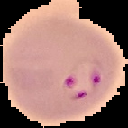

In [27]:
# 이미지 불러오기 확인 
def img_prep(img) : 
  img = img.resize((img_size,img_size)) 
  return img 

img0 = Image.open('gdrive/My Drive/dataset/Malaria/Parasitized_sample/C33P1thinF_IMG_20150619_114756a_cell_179.png') 
img_size = 128 
img_prep(img0)

In [0]:
# 데이터셋 나누기
# 추후 train set, test set 나눌 때 set 별 label 비율이 인위적으로 고정되지 않기 위해 전체 이미지를 라벨링 해서 하나의 데이터 셋으로 만듦
# glob 라는 함수로 전체 파일을 다 불러올 수 있다는데 해보다 잘 안돼서 이건 추후에 해보겠음 
# from glob import glob 
# data_list = glob('gdrive/My Drive/dataset/Malaria/*/*.png')  

np.random.seed(3824)

img_size = 128
channel = 3

def img_prep(img) : 
  img = img.resize((img_size,img_size)) 
  return img 

dataset_name = 'Malaria' 

img_list = []
label_list = []
total_imgs = []
total_labels = []

for folder in ['Uninfected_sample','Parasitized_sample']:
  for file in os.listdir('gdrive/My Drive/dataset/{}/{}'.format(dataset_name,folder)):
    try:
      file_path = 'gdrive/My Drive/dataset/{}/{}/{}'.format(dataset_name,folder,file)
      img = Image.open(file_path)
      img_p = img_prep(img)
    
      img_list.append(np.array(img_p))
       
      if folder =='Uninfected_sample':
        label_onehot = np.array([0,1])

      elif folder =='Parasitized_sample':
        label_onehot = np.array([1,0])

      label_list.append(np.array(label_onehot))
            
      total_imgs = np.array(img_list).reshape(len(img_list),img_size,img_size,channel)
      total_labels = np.array(label_list).reshape(len(label_list),2)
    except:
      pass


In [76]:
# train/test set 나누기 

from sklearn.model_selection import train_test_split  

train_imgs, test_imgs, train_labels, test_labels = train_test_split(total_imgs, total_labels, test_size=0.25, shuffle=True, random_state=1234) 

print(train_imgs.shape)
print(test_imgs.shape)
print(train_labels.shape)
print(test_labels.shape)
print(test_labels[:9])

(1983, 128, 128, 3)
(661, 128, 128, 3)
(1983, 2)
(661, 2)
[[0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]]


# 모델


In [77]:
# 모델 구성 
model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.summary()

# 모델 학습과정 설정 
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 조기종료함수 
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience = 5) # 조기종료 콜백함수 정의

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 16, 16, 128)       73856     
__________

Train on 1983 samples, validate on 661 samples
Epoch 1/20
1983/1983 [==============================] - 4s 2ms/step - loss: 7.6518 - acc: 0.5169 - val_loss: 7.3641 - val_acc: 0.5431
Epoch 2/20
1983/1983 [==============================] - 2s 948us/step - loss: 7.8030 - acc: 0.5159 - val_loss: 7.3641 - val_acc: 0.5431
Epoch 3/20
1983/1983 [==============================] - 2s 951us/step - loss: 7.8030 - acc: 0.5159 - val_loss: 7.3641 - val_acc: 0.5431
Epoch 4/20
1983/1983 [==============================] - 2s 950us/step - loss: 7.8030 - acc: 0.5159 - val_loss: 7.3641 - val_acc: 0.5431
Epoch 5/20
1983/1983 [==============================] - 2s 952us/step - loss: 7.8030 - acc: 0.5159 - val_loss: 7.3641 - val_acc: 0.5431
Epoch 6/20
1983/1983 [==============================] - 2s 950us/step - loss: 7.8030 - acc: 0.5159 - val_loss: 7.3641 - val_acc: 0.5431


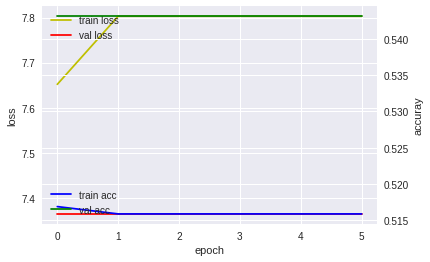

In [75]:
# 모델 학습
hist = model.fit(train_imgs, train_labels,
                batch_size=64,
                epochs=20,
                validation_data=(test_imgs, test_labels),
                callbacks=[early_stopping] 
                )

# 모델 학습 과정 표시하기 
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

Train: [   0    1    2 ... 1980 1981 1982] Valid: [  12   18   21   28   31   35   42   43   50   54   61   63   64   66
   75   86   87   91   94  103  104  108  110  112  114  115  119  120
  129  131  132  142  147  148  155  156  167  182  184  189  204  206
  209  210  218  221  226  229  235  239  252  256  257  260  261  266
  270  273  276  277  297  301  304  306  308  309  310  314  315  319
  320  326  327  328  336  343  351  356  357  372  382  384  388  394
  403  410  421  427  429  433  437  440  449  450  452  466  468  478
  483  489  498  512  520  522  524  525  535  546  547  550  553  554
  556  558  561  564  566  585  590  594  600  611  613  614  615  630
  633  637  641  644  650  653  667  670  679  680  682  698  700  701
  708  715  722  724  732  733  735  738  742  748  761  772  775  779
  784  787  792  797  798  807  809  814  817  822  828  831  842  847
  850  857  860  861  868  870  878  879  883  895  903  905  907  909
  910  912  914  917  918  

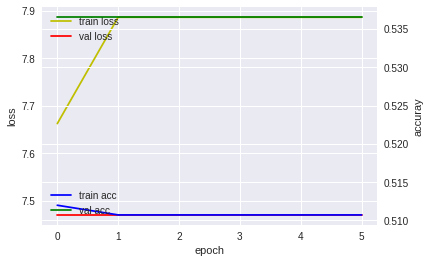

Train: [   1    2    3 ... 1980 1981 1982] Valid: [   0    5   13   15   19   33   36   37   45   48   65   69   72   76
   78   84   85   95   97   98  116  127  130  134  136  138  141  150
  151  152  154  157  161  162  163  166  169  171  172  173  185  188
  196  203  208  216  223  233  237  246  249  250  258  263  267  275
  278  282  286  302  303  307  316  318  332  334  346  348  352  353
  368  374  375  376  379  381  385  392  393  395  406  408  409  431
  448  453  457  458  462  463  472  474  482  491  499  502  511  517
  521  528  533  542  543  565  568  569  579  582  584  587  597  598
  599  602  605  616  624  627  645  646  647  651  654  655  656  657
  666  668  674  676  678  683  689  691  696  702  711  717  721  726
  734  737  746  749  753  756  759  764  776  777  778  785  800  803
  805  813  820  824  827  835  838  840  841  853  854  856  865  866
  871  875  890  891  893  902  906  911  923  925  929  937  944  945
  947  949  956  961  966  

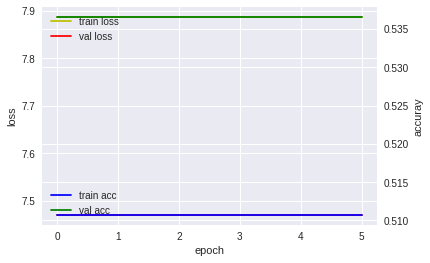

Train: [   0    1    2 ... 1979 1981 1982] Valid: [   4    7    9   10   20   23   27   30   40   41   44   49   52   55
   56   57   62   67   68   79   80   81   83   90  100  102  109  117
  122  123  124  128  144  145  160  164  170  175  176  177  178  186
  187  190  195  198  200  201  205  212  219  228  230  234  240  243
  244  245  251  272  274  279  280  283  285  289  291  292  294  298
  299  300  305  313  317  324  331  338  344  345  362  367  369  373
  386  387  391  396  397  399  414  415  417  418  423  426  428  436
  444  446  456  469  476  479  486  490  497  500  501  507  510  523
  529  531  534  541  548  560  567  570  578  580  586  591  595  603
  610  617  620  621  623  626  628  632  642  643  659  663  671  681
  684  685  688  692  694  697  704  705  706  707  710  712  714  723
  725  728  729  736  741  743  754  758  760  767  773  780  782  783
  786  793  802  810  811  812  816  825  829  833  834  839  848  849
  858  863  876  882  887  

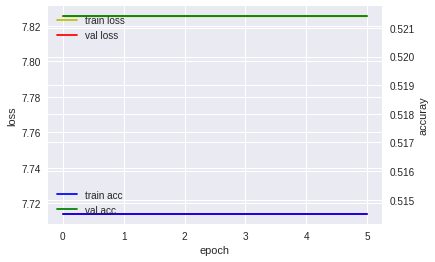

Train: [   0    1    2 ... 1980 1981 1982] Valid: [   6   11   22   24   26   29   32   34   38   59   70   71   74   82
   89   93  101  105  107  118  121  125  126  153  159  174  179  180
  181  183  191  192  199  202  207  211  214  217  222  225  227  231
  232  236  241  242  248  253  254  264  268  269  284  287  288  295
  311  329  333  335  341  347  349  354  358  363  364  365  366  370
  377  378  389  398  400  402  404  413  416  419  425  430  435  443
  445  447  455  461  465  470  485  487  492  505  506  508  509  513
  514  518  526  527  532  536  538  540  545  549  551  559  563  571
  577  581  606  607  619  625  631  640  648  652  660  662  664  669
  672  675  677  687  690  693  699  703  709  713  716  719  727  730
  739  740  745  747  765  768  770  771  774  788  789  794  796  799
  801  804  808  821  823  832  844  845  851  852  859  864  869  872
  873  874  877  880  888  892  894  897  904  908  915  916  919  920
  921  922  936  941  943  

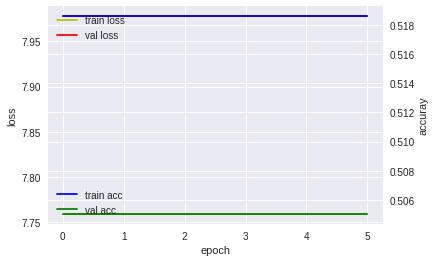

Train: [   0    4    5 ... 1977 1978 1980] Valid: [   1    2    3    8   14   16   17   25   39   46   47   51   53   58
   60   73   77   88   92   96   99  106  111  113  133  135  137  139
  140  143  146  149  158  165  168  193  194  197  213  215  220  224
  238  247  255  259  262  265  271  281  290  293  296  312  321  322
  323  325  330  337  339  340  342  350  355  359  360  361  371  380
  383  390  401  405  407  411  412  420  422  424  432  434  438  439
  441  442  451  454  459  460  464  467  471  473  475  477  480  481
  484  488  493  494  495  496  503  504  515  516  519  530  537  539
  544  552  555  557  562  572  573  574  575  576  583  588  589  592
  593  596  601  604  608  609  612  618  622  629  634  635  636  638
  639  649  658  661  665  673  686  695  718  720  731  744  750  751
  752  755  757  762  763  766  769  781  790  791  795  806  815  818
  819  826  830  836  837  843  846  855  862  867  881  884  885  886
  889  896  899  900  901  

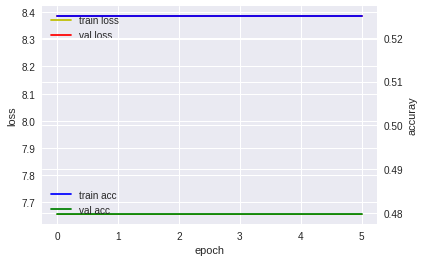

In [78]:
# K-fold cross validation
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
# https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6

from sklearn.model_selection import KFold

x = np.array(train_imgs)
y = np.array(train_labels)

kf = KFold(n_splits=5, shuffle=True, random_state=123)


# 모델 학습시키기 
# K-fold

for train_index, valid_index in kf.split(x,y):
  print("Train:",train_index, "Valid:",valid_index)
  x_train, x_valid = x[train_index], x[valid_index]
  y_train, y_valid = y[train_index], y[valid_index]
  
  hist = model.fit(x_train, y_train,
                   batch_size=64,
                   epochs=20,
                   validation_data=(x_valid, y_valid),
                   callbacks=[early_stopping] )  
  
  print("-- Evaluate --")
  scores = model.evaluate(x_valid, y_valid, batch_size=64)
  print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))
    

  %matplotlib inline
  import matplotlib.pyplot as plt

  fig, loss_ax = plt.subplots()

  acc_ax = loss_ax.twinx()

  loss_ax.plot(hist.history['loss'], 'y', label='train loss')
  loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

  acc_ax.plot(hist.history['acc'], 'b', label='train acc')
  acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

  loss_ax.set_xlabel('epoch')
  loss_ax.set_ylabel('loss')
  acc_ax.set_ylabel('accuray')

  loss_ax.legend(loc='upper left')
  acc_ax.legend(loc='lower left')

  plt.show()

In [79]:
# 모델 평가 및 사용하기
print("-- Evaluate --")
scores = model.evaluate(test_imgs, test_labels, batch_size=32)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

print("-- Predict --")
output = model.predict(test_imgs)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(output)

-- Evaluate --
661/661 [==============================] - 0s 487us/step
acc: 54.31%
-- Predict --
[[0.000 1.000]
 [0.000 1.000]
 [0.000 1.000]
 ...
 [0.000 1.000]
 [0.000 1.000]
 [0.000 1.000]]
